# LangGraph w/ MCP

---


# 1. imports

In [ ]:
# =====================================================
# === 1. imports ( 8 LOC ) ============================
# =====================================================
import cudf.pandas
cudf.pandas.install()
import pandas as pd

from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.prebuilt import ToolNode
from langchain_openai import ChatOpenAI
from langchain_mcp_adapters.client import MultiServerMCPClient


# 2. LLM
### Qwen 2.5, 14B, Instruct
### Serviced by SGLang

In [ ]:
# =====================================================
# === 2. LLM Setup  ( 1 LOC ) =========================
# =====================================================
llm = ChatOpenAI(
    model="Qwen/Qwen2.5-14B-Instruct",
    base_url="http://localhost:30000/v1",
    api_key="not-used",  # required by ChatOpenAI, ignored by SGLang
            
    temperature=0.1,
    max_tokens=None,
    stream_usage=True,  # Include token usage in streaming responses
)

# 3. MCP Tooling

In [3]:
# =====================================================
# === 3. MCP Tools (async initialization) =============
# =====================================================
async def get_mcp_tools():
    """Fetch MCP tools from the server."""
    client = MultiServerMCPClient(
        {
            "stock-tools": {
                "url": "http://localhost:8000/sse",
                "transport": "sse",
            }
        }
    )
    return await client.get_tools()

mcp_tools = await get_mcp_tools()

# 4. LangGraph Agent/Node

In [ ]:
# =====================================================
# === 4. LLM - Qwen  ( 5 LOC ) ========================
# =====================================================
llm_with_tools = llm.bind_tools(mcp_tools)

# Tool-calling agent node (uses fast local SGLang)
def tool_caller(state: MessagesState):
    """Fast local LLM for tool selection and calling."""
    system = SystemMessage(
        content="""You are a stock market assistant. Select and call the appropriate tool based on the user's request.
        - Use get_ohlc_from_prompt for data/prices/OHLC requests
        - Use plot_ohlc_from_prompt for chart/plot/visualization/animation requests
        """
    )
    messages = [system] + state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


# 5. LangGraph App

In [ ]:
# =====================================================
# === 5. LangGraph App  ( 10 LOC ) ====================
# =====================================================

# Routing: if tool_caller made a tool call, go to tools; else END
def route_after_tool_caller(state: MessagesState):
    last_msg = state["messages"][-1]
    if hasattr(last_msg, "tool_calls") and last_msg.tool_calls:
        return "tools"
    return END

# Build graph: tool_caller -> tools -> END
graph = StateGraph(MessagesState)
graph.add_node("tool_caller", tool_caller)  # Fast local SGLang
graph.add_node("tools", ToolNode(mcp_tools))

graph.add_edge(START, "tool_caller")
graph.add_conditional_edges("tool_caller", route_after_tool_caller, ["tools", END])
graph.add_edge("tools", END)

app = graph.compile()

### DIY "Studio" 🤣

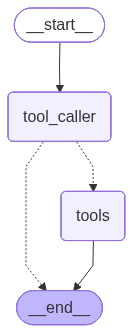

In [13]:
app

---

# 6. Multi-Modal Streaming Output
### Returns
 * pandas DataFrame of OHCL
 * Plotly Stock Candles visualization

In [ ]:
# =====================================================
# === 6. Multi-Modal Output ( 48 LOC ) ================
# =====================================================
import plotly.graph_objects as go
from io import StringIO
import json

# ANSI color codes
DIM_GREEN = "\033[2;32m"
YELLOW = "\033[93m"
CYAN = "\033[96m"
GRAY = "\033[38;5;241m"
BLUE = "\033[94m"
MAGENTA = "\033[95m"
RESET = "\033[0m"

async def stream_invoke(prompt: str):
    """Stream agent execution with verbose output, return DataFrame or Plotly figure."""
    print(f'{GRAY}PROMPT: "{prompt}"{RESET}\n')
    inputs = {"messages": [HumanMessage(content=prompt)]}
    result_obj = None

    async for event in app.astream(inputs, stream_mode="updates"):
        for node_name, output in event.items():
            if node_name == "tool_caller":
                msg = output["messages"][0]
                print(f"{MAGENTA}[SGLang 14B]{RESET}")
                
                # Show reasoning/content if present
                if msg.content:
                    print(f"{DIM_GREEN}{msg.content}{RESET}")
                
                # Show tool calls
                if hasattr(msg, "tool_calls") and msg.tool_calls:
                    for tc in msg.tool_calls:
                        print(f"{YELLOW}[Tool Call: {tc['name']}]{RESET}")
                        print(f"{BLUE}Args: {tc['args']}{RESET}")
                
                # Show token usage if available
                if hasattr(msg, "usage_metadata") and msg.usage_metadata:
                    u = msg.usage_metadata
                    print(f"{GRAY}Tokens: in={u.get('input_tokens', '?')} out={u.get('output_tokens', '?')}{RESET}")
                elif hasattr(msg, "response_metadata") and msg.response_metadata:
                    rm = msg.response_metadata
                    if "token_usage" in rm:
                        tu = rm["token_usage"]
                        print(f"{GRAY}Tokens: in={tu.get('prompt_tokens', '?')} out={tu.get('completion_tokens', '?')}{RESET}")
                print()

            elif node_name == "tools":
                for msg in output["messages"]:
                    result = msg.content
                    print(f"{CYAN}[Tool Result]{RESET}")                    
                    # Try to parse as JSON (plot data)
                    try:
                        data = json.loads(result)
                        if "error" in data:
                            print(f"{YELLOW}{data['error']}{RESET}")
                            result_obj = data["error"]
                        elif data.get("type") == "candlestick":
                            print(f"{DIM_GREEN}Candlestick data: {data['ticker']} ({data['period']}, {data['interval']}){RESET}")
                            print(f"{GRAY}{len(data['dates'])} data points{RESET}")
                            # Reconstruct Plotly figure
                            fig = go.Figure(data=[go.Candlestick(
                                x=data["dates"],
                                open=data["open"],
                                high=data["high"],
                                low=data["low"],
                                close=data["close"],
                                name=data["ticker"],)])
                            fig.update_layout(
                                title=f"{data['ticker']} OHLC ({data['period']}, {data['interval']})",
                                template="plotly_dark",
                                xaxis_title="Date",
                                yaxis_title="Price",)
                            result_obj = fig
                        continue
                    except json.JSONDecodeError:
                        pass
                    
                    # Parse as DataFrame (OHLC table data)
                    lines = result.strip().split("\n")
                    # Show truncated preview
                    preview = result[:300] + "..." if len(result) > 300 else result
                    print(f"{DIM_GREEN}{preview}{RESET}")
                    
                    data_start = 0
                    for i, line in enumerate(lines):
                        if "Date" in line and "Open" in line:
                            data_start = i
                            break
                    if data_start > 0 or "Date" in lines[0]:
                        table_text = "\n".join(lines[data_start:])
                        df = pd.read_csv(StringIO(table_text), sep=r"\s+")
                        print(f"{GRAY}{len(df)} rows{RESET}")
                        result_obj = df
                    else:
                        result_obj = result
                print()

    return result_obj

---

# Test 1 - Return a pandas DataFrame

In [11]:
df = await stream_invoke("Get OHLC data for SPY for the last 1 month")
df

PROMPT: "Get OHLC data for SPY for the last 1 month"

[SGLang 14B]
[Tool Call: get_ohlc]
Args: {'ticker': 'SPY', 'period': '1mo'}
Tokens: in=577 out=30

[Tool Result]
📈 SPY OHLC Data (1mo, 1d)
      Date   Open   High    Low  Close    Volume
2025-11-10 677.24 682.18 675.03 681.44  75842900
2025-11-11 679.95 683.57 678.73 683.00  58953400
2025-11-12 684.79 684.96 680.95 683.38  62312500
2025-11-13 680.50 680.86 670.52 672.04 103457800
2025-11-14 665.38 675.66 663....
21 rows



,Date,Open,High,Low,Close,Volume
0,2025-11-10,677.24,682.18,675.03,681.44,75842900
1,2025-11-11,679.95,683.57,678.73,683.00,58953400
2,2025-11-12,684.79,684.96,680.95,683.38,62312500
3,2025-11-13,680.50,680.86,670.52,672.04,103457800
4,2025-11-14,665.38,675.66,663.27,671.93,96846700
5,2025-11-17,669.70,673.71,662.17,665.67,90456100
6,2025-11-18,662.10,665.12,655.86,660.08,114467500
7,2025-11-19,660.78,667.34,658.75,662.63,94703000
8,2025-11-20,672.91,675.56,651.89,652.53,165293500
9,2025-11-21,655.05,664.55,650.85,659.03,123956200


# Test 2 - Return a Plotly Plot

In [12]:
fig = await stream_invoke("Plot a daily (1d) intervals candlestick chart for NVDA for 3 years")
fig.show()

PROMPT: "Plot a daily (1d) intervals candlestick chart for NVDA for 3 years"

[SGLang 14B]
[Tool Call: plot_ohlc]
Args: {'ticker': 'NVDA', 'period': '3y'}
Tokens: in=582 out=30

[Tool Result]
Candlestick data: NVDA (3y, 1d)
751 data points

